In [45]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import random
import netCDF4 as nc

In [2]:
#Load transformed (SINMOD grid) coral data
coral_filepath = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_sinmod_grid.parquet'
coral_data = pd.read_parquet(coral_filepath)

coral_x = coral_data['x']
coral_y = coral_data['y']

In [3]:
#Load SINMOD data 
filename_sinmod = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

sinmod_data = Dataset(filename_sinmod, 'r')


In [4]:
#Load data for stat. northness and eastness
filename_jan_jun = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

jan_jun_data = Dataset(filename_jan_jun, 'r')


In [21]:
#Now plot a histogram for a chosen feature at coral data points 

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, jan_jun_data=False, current_aspect_angle=False, generate_random=False):
    
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    #Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            #Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                elif variable_name in ['statistical_eastness', 'statistical_northness']:
                    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                    longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                    theta = longitude_at_point - longitude_of_projection_origin
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                    aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                    if variable_name == 'statistical_eastness':
                        value = np.sin(aspect)
                    else:
                        value = np.cos(aspect)
                        
                elif variable_name == 'current_aspect_angle':
                    try:
                        value = current_aspect_angle.variables[int(y), int(x)]
                    except KeyError:
                        value = np.nan  

                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    #Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    #Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    #Plot histogram of the combined variable values

    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()
    plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_coral_points.png')
 

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        #Plotting histogram at random locations
        
        no_points = int(len(valid_coordinates)/(t_stop - t_start))

        #Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                    elif variable_name in ['statistical_eastness', 'statistical_northness']:
                        longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                        longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                        else:
                            value = np.cos(aspect)
                            
                    elif variable_name == 'current_aspect_angle':
                        try:
                            value = current_aspect_angle.variables[int(y), int(x)]
                        except KeyError:
                            value = np.nan  
                       
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        #Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        #Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        #Plot histogram at random points
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}', fontsize = 14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.show()
        plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_random_points.png')

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        #Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10),
            'std': np.std(coral_values_flat, ddof=1), #std
            'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats}")
    return coral_values, random_values


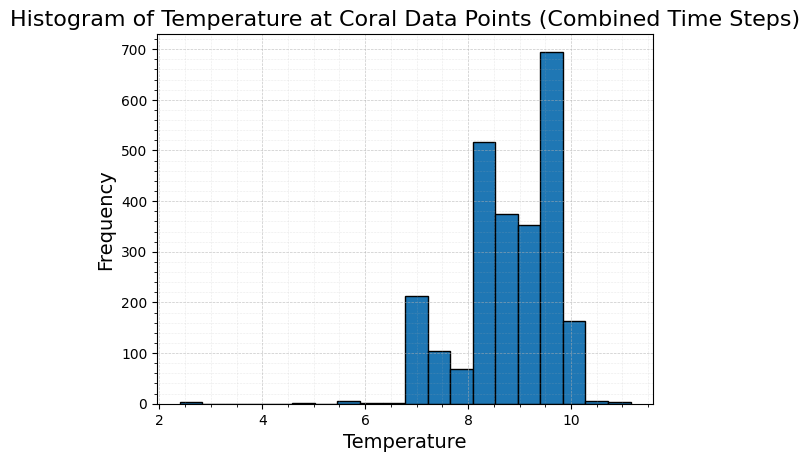

Number of valid coordinates: 836.0 out of 1718


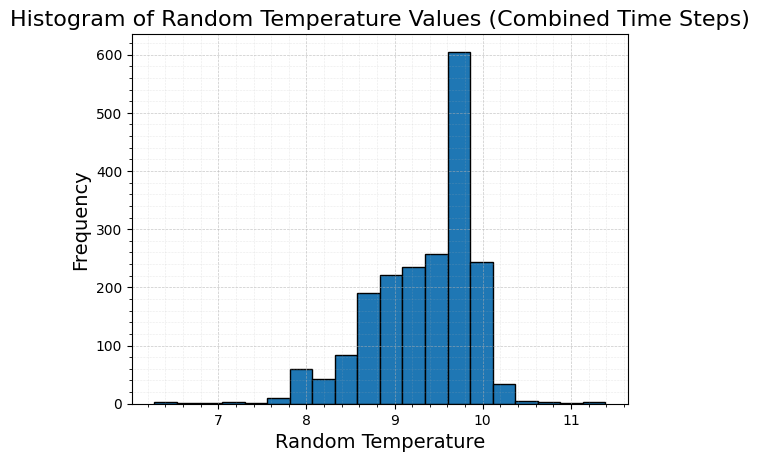

Number of valid random coordinates: 667.6666666666666 out of 1718
Statistics for coral values: {'mean': np.float32(8.821998), 'max': np.float32(11.155919), 'min': np.float32(2.3927116), '90th_percentile': np.float32(9.703055), '10th_percentile': np.float32(7.349431), 'std': np.float32(0.8795186), 'cv': np.float32(0.099696085)}


<Figure size 640x480 with 0 Axes>

In [23]:
#Plot histograms for desired features
tmax = len(sinmod_data.variables['time'])

#coral_values_salinity, random_values_salinity = plot_histogram_at_coral_points(sinmod_data, coral_data, 'salinity', (0, tmax), False, False, True)
#coral_values_stat_north, random_values_stat_northness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_northness', (0, tmax), jan_jun_data, False, True)
#coral_values_stat_eastness, random_values_stat_eastness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_eastness', (0, tmax), jan_jun_data, False, True)
#coral_values_current_speed, random_values_current_speed = plot_histogram_at_coral_points(sinmod_data, coral_data, 'current_speed', (0, tmax), False, False, True)
#coral_values_temperature, random_values_temperature = plot_histogram_at_coral_points(sinmod_data, coral_data, 'temperature', (0, tmax), False, False, True)

coral_values_temperature, random_values_temperature = plot_histogram_at_coral_points(sinmod_data, coral_data, 'temperature', (0, 3), False, False, True)


In [ ]:
#Histograms for current aspect angle

filename_current_aspect = '/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc'
current_aspect_data = Dataset(filename_current_aspect, 'r')


coral_file_emod_grid = '/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/midnor_total_coral_data_filtered_UTM32N.parquet'
coral_ds_emod_grid = pd.read_parquet(coral_file_emod_grid)


xc_max = current_aspect_data.variables['x'].shape[0]
yc_max = current_aspect_data.variables['y'].shape[0]

t_start, t_stop = (0,3) #len(current_aspect_data.variables['current_aspect_angle'])

coral_values = []
valid_coordinates = []

for time in range(t_start, t_stop):

    for x, y in zip(coral_ds_emod_grid['x'], coral_ds_emod_grid['y']):
            
            if 0 <= x <= xc_max and 0 <= y <= yc_max:
                try:
                    value = current_aspect_angle.variables[int(y), int(x)]
                except KeyError:
                    value = np.nan  

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))
coral_values = np.array(coral_values)

coral_values_flat = coral_values.flatten()

plt.hist(coral_values_flat, bins=20, edgecolor='black')
plt.xlabel('Current Aspect Angle', fontsize = 14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Current Aspect Angle at Coral Data Points (Combined Time Steps)', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
plt.show()
plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/current_aspect_angle_histogram_coral_points.png')


print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

#Plotting histogram at random locations
        
no_points = int(len(valid_coordinates)/(t_stop - t_start))

#Generate same number of valid co-ords as random x and y locations within the grid
valid_xc_yc_indices = np.argwhere(~current_aspect_data.variables['bottom_temperature_features'][0,0].mask)

selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

random_values = []
random_valid_coordinates = 0

for time in range(t_start, t_stop):
    for y, x in selected_indices:
        if 0 <= x <= xc_max and 0 <= y <= yc_max:
            try:
                value = current_aspect_angle.variables[int(y), int(x)]
            except KeyError:
                value = np.nan  
                       
                if not np.ma.is_masked(value):
                    random_values.append(value)
                    random_valid_coordinates += 1
        
#Convert list to numpy array for easier manipulation
random_values = np.array(random_values)

#Flatten the array to combine all time steps
random_values_flat = random_values.copy().flatten()

#Plot histogram at random points
plt.hist(random_values_flat, bins=20, edgecolor='black')
plt.xlabel(f'Random Current Aspect Angle', fontsize = 14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of Random Current Aspect Angle Values (Combined Time Steps)', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
plt.show()
plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/current_aspect_angle_histogram_random_points.png')

print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

#Calculate statistics for coral values
stats = {
    'mean': np.mean(coral_values_flat),
    'max': np.max(coral_values_flat),
    'min': np.min(coral_values_flat),
    '90th_percentile': np.percentile(coral_values_flat, 90),
    '10th_percentile': np.percentile(coral_values_flat, 10),
    'std': np.std(coral_values_flat, ddof=1), #std
    'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
}

print(f"Statistics for coral values: {stats}")



In [40]:
#Box plots 
def plot_comparison_boxplots(coral_values, random_values, variable_name):
    
    data = [coral_values, random_values]
    labels = ['Coral Values', 'Random Values']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, tick_labels=labels)
    plt.xticks(fontsize=14) 
    plt.ylabel(variable_name.capitalize(), fontsize=14)
    plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations', fontsize=16)
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Control grid appearance
    plt.show()
    plt.savefig(f'/cluster/home/maikents/features_midnor_2019/boxplots/{variable_name}_comparison_boxplot.png')



In [ ]:
#Plot boxplots for desired features
#plot_comparison_boxplots(coral_values_salinity, random_values_salinity, 'salinity')
#plot_comparison_boxplots(coral_values_stat_north, random_values_stat_north, 'statistical_northness')
#plot_comparison_boxplots(coral_values_stat_eastness, random_values_stat_eastness, 'statistical_eastness')
#plot_comparison_boxplots(coral_values_current_speed, random_values_current_speed, 'current_speed')
#plot_comparison_boxplots(coral_values_temperature, random_values_temperature, 'temperature')

In [49]:
#Histograms for EMOD features
EMOD_features = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/emod_features/emod_complete_xy.nc')
print(list(EMOD_features.variables))

['xc', 'yc', 'aspect_cos', 'aspect_sin', 'bathymetry_32N', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness', 'slope']
